In [1]:
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict

import copy

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader

***
### Data Preparation

In [2]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784',version=1, return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X/255, y, test_size=0.2, random_state=42)
X_train = X_train[:2000]
y_train = y_train[:2000]

X_test = X_test[:500]
y_test = y_test[:500]

y_train = y_train.astype('int32')
y_test = y_test.astype('int32')

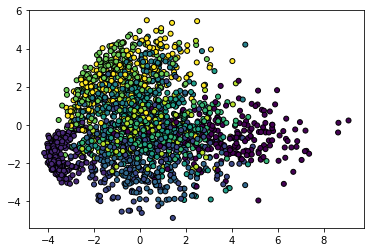

In [20]:
x_pca = PCA(n_components=2) # 10 bagus, 2 ini buat ngeplot dec-boundary aja
X_pca_train = x_pca.fit_transform(X_train)

x_pca = PCA(n_components=X_pca_train.shape[1])
X_pca_test = x_pca.fit_transform(X_test)
plt.scatter(X_pca_train[:, 0], X_pca_train[:, 1], marker='o', c=y_train,
            s=25, edgecolor='k')

In [21]:
sum(x_pca.explained_variance_ratio_)

0.17215482295149054

In [ ]:
# No PCA is okay too
#   for visualization purpose, only restrict first 2 feature
x_train = X_train[:, :2] 
x_test = X_test[:, :2] 

plt.scatter(x_train[:, 0], x_train[:, 1], marker='o', c=y_train,
            s=25, edgecolor='k')

***
## Utility and Support

Tanh:
$$ tanh(x)=\frac { { e }^{ x }-{ e }^{ -x } }{ { e }^{ z }+{ e }^{ -x } } $$

In [3]:
class Activation(object):
    
    def sigmoid(self, x, derivative=False):
        def base(x):
            return 1 / (1 + np.exp(-x))
        
        if not derivative:
            return base(x)
        else:
            return self.__sigmoidDerivative(base(x))

    def __sigmoidDerivative(self, x):
        # implementasi ini jika input x BELUM berupa hasil dari sigmoid
        # return self.sigmoid(x) *  (1 - self.sigmoid(x))
        return x *  (1 - x)
    
    def softmax(self, z, derivative=False):
        # np.exp is not stable because it has Inf. So you should subtract maximum in x
        z -= np.max(z)
        
        def base(z):
            return np.exp(z) / np.exp(z).sum(axis=1, keepdims=True)

        if not derivative:
            return base(z)
        else:
            return self.__softmaxDerivative(base(z))
    
    def __softmaxDerivative(self, x):
        # implementasi ini jika input x BELUM berupa hasil dari sigmoid
        p=x
        return p * (1-p)
    
    def relu(self, x, derivative=False):
        # np.heaviside(x, 0) <<-- sama
        #https://stackoverflow.com/questions/32109319/how-to-implement-the-relu-function-in-numpy
        return x * (x > 0)
    
    def softSign(self, x, derivative=False):
        x = abs(x)
        
        if derivative:
            return self.__softSignDerivative(x)
        else:
            return x/(1+x)
    
    def __softSignDerivative(self, x):
        return 1/((1+x))**2
    
    def tanh(self, x, use_np_tanh=False, derivative=False):
        # numpy tanh is faster
        # >>  %timeit -n10000 np.tanh(x)
        # ... 1.32 µs ± 333 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
        def base(x):
            return np.tanh(x)

        if not use_np_tanh:
            if not derivative:
                return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))
            else:
                return self.__tanhDerivative(base(x))
        else:
            if not derivative:
                return base(x)
            else:
                return self.__tanhDerivative(base(x))
        
    def __tanhDerivative(self, x):
        # http://ronny.rest/blog/post_2017_08_16_tanh/
        t = x
        return 1 - t**2
    
    def swish(self, x, derivative=False):
        def base(x):
            return x * self.sigmoid(x)
        
        if not derivative:
            return base(x)
        else:
            return base(x) + (self.sigmoid(x)*(1 - base(x)))

In [4]:
class HypotesisFunction(object):
    def __call__(self, x_val, theta, transpose=False):
        try:
            if not transpose:
                return x_val @ theta
            else:
                return x_val @ theta.T
        except Exception as ex:
            print(ex)

def dropout(X, drop_probability):
    keep_probability = 1 - drop_probability
    mask = np.random.binomial(1, drop_probability, size=X.shape)
    #############################
    #  Avoid division by 0 when scaling
    #############################
    if keep_probability > 0.0:
        scale = (1/keep_probability)
    else:
        scale = 0.0
    return mask * X * scale

def to_onehot(y_val, num_classes=2):
    return (np.arange(num_classes + 1) == y_val[:, None]).astype(float)

class Loss(object):
    # Binary Cross-Entropy
    def binaryCrossEntropy(self, y_real, y_pred, eps=1e-8, **kwargs):
        h_p = np.log(y_pred + eps)
        d_pq = np.log(1 - y_pred + eps)
        return 1 / len(y_real) * -np.sum(
                            y_real * h_p + (1-y_real) * d_pq
                        )

    # Categorical Cross-Entropy
    def categoricalCrossEntropy(self, y_real, y_pred, epsilon=1e-12, grad=False, **kwargs):
        # https://stackoverflow.com/questions/47377222/what-is-the-problem-with-my-implementation-of-the-cross-entropy-function
        """
        Computes cross entropy between targets (encoded as one-hot vectors)
        and predictions. 
        Input: predictions (N, k) ndarray
               targets (N, k) ndarray        
        Returns: scalar
        """
        y_pred = np.clip(y_pred, epsilon, 1. - epsilon)
        if not grad:
            N = y_pred.shape[0]
            ce = -np.sum(y_real*np.log(y_pred + 1e-9))/N
            return ce
        else:
            return -(y_real/y_pred) + (1-y_real)/(1-y_pred)
    
    def mse(self, y_pred, y_real, theta=None, regularized=False, lambd=1, m=None, loss_type='l2'):
        # squared error for regression or
        # MSE a.k.a mean of the sum of square error
        if m is None:
            m = y_pred.shape[0]

        if loss_type == 'l1':
            return np.average(np.abs(y_real - y_pred))
        else:
            if regularized:
                # l2 regularization
                magnitude = np.linalg.norm(theta)

                reg_term = (lambd/m) * np.square(magnitude)

                return np.square(np.subtract(y_real, y_pred)).mean() + reg_term
            else:
                return ((1/(2*m)) * np.square(np.subtract(y_real, y_pred)).sum())

***
## Solution and Optimization

In [5]:
class LinearLayer(object):
    def __init__(self, num_features, num_hidden, hypo_function, weight_initializer='xavier',
                 xavier_init_type=2):
        if weight_initializer == 'he':
            # He-et-al Initializer
            #  pair with relu activation
            self.weight = np.random.normal(0, 1, (num_features, num_hidden)) * np.sqrt(2. / num_features)
        elif weight_initializer == 'xavier':
            # Glorot & Bengio 1
            #  pair with tanh activation
            if xavier_init_type == 1 or xavier_init_type==3:
                if xavier_init_type == 1:
                    # standar initialization, softsign prefered
                    lim =  np.sqrt(1. / num_features)
                else:
                    # normalized initialization, tanh prefered
                    lim =  np.sqrt(6. / (num_features+num_hidden))
                    
                self.weight = np.random.uniform(-lim, lim, (num_features, num_hidden))
            else:
                self.weight = np.random.normal(0, 1, (num_features, num_hidden)) * \
                                np.sqrt(2. / (num_features+num_hidden))
            
        else:
            # Common weight initializer
            self.weight = np.random.normal(0, 1, (num_features, num_hidden))
        
        self.bias = np.zeros((1, num_hidden))
        self.hypo_function = hypo_function

    def forward(self, x_val):
        self.fitted_value = self.hypo_function(x_val, self.weight) + self.bias
        return self

class MLP(object):
    def __init__(self, feature_num, label_num, hidlayer_num,
                 hidden_activation, output_activation, hypo_function,
                 shuffle=False, alpha=10e-4, epoch=100, batch_size=1,
                 dropout_size=0.5, eps=1e-8, **kwargs):

        # silahkan un-comment hidden layer lainnya kalao ingin menggunakan lebih dari 1 layer
        self.models = {
                       "hd_1": LinearLayer(feature_num, hidlayer_num, hypo_function, 
                                           weight_initializer='normal'),
                       #"hd_2": LinearLayer(hidlayer_num, hidlayer_num, hypo_function,
                       #                    weight_initializer='normal'),
                       #"hd_3": LinearLayer(hidlayer_num, hidlayer_num, hypo_function,
                       #                    weight_initializer='normal'),
                       "out_1": LinearLayer(hidlayer_num, label_num, hypo_function)
                      }
        
        self.shuffle = shuffle
        self.lr = alpha
        self.epoch = epoch
        self.batch_size = batch_size
        self.dropout_size = dropout_size
        self.eps = eps
        
        self.hidden_activation = hidden_activation
        self.output_activation = output_activation
        self.hypo_function = hypo_function
        
        self.kwargs = kwargs
        
    def gradientOptimizer(self, gradient, theta, gamma, epoch_t, ix):
        theta_copy = copy.copy(theta)

        if self.kwargs.get('use_momentum', False):
            # standard momentum strategy
            self.velocity[ix] = gamma * self.velocity[ix] + self.lr * gradient 
            theta -= self.velocity[ix]
        elif self.kwargs.get('use_rmsprop', False):
            self.velocity[ix] = gamma * self.velocity[ix] + ((1 - gamma) * (gradient **2))
            
            # update parameter
            theta -= (self.lr / (np.sqrt(self.velocity[ix]) + self.eps)) * gradient
        elif self.kwargs.get('use_adam', False):
            epoch_t+=1
            beta1 = .9
            beta2 = .999
            
            # kalau jumlah parameter_theta > 1, M dan R menyesuaikan
            self.M[ix] = beta1 * self.M[ix] + (1. - beta1) * gradient #updates the moving averages of the gradient
            self.R[ix] = beta2 * self.R[ix] + (1. - beta2) * gradient**2 #updates the moving averages of the squared gradient

            m_k_hat = self.M[ix] / (1. - beta1**(epoch_t)) #calculates the bias-corrected estimates
            r_k_hat = self.R[ix] / (1. - beta2**(epoch_t)) #calculates the bias-corrected estimates
            
            theta -= self.lr * m_k_hat / (np.sqrt(r_k_hat) + self.eps)
        
    def forward(self, x_val, is_training=True):
        #~~~~~~~~ Forward Propagation
        forward_prod = defaultdict(dict)
        
        last_d_key = None
        for ix, d_key in enumerate(self.models):
            if ix==0:
                # fix operation for first layer
                forward_prod[d_key]['z']=self.models[d_key].forward(x_val).fitted_value
                forward_prod[d_key]['z_act'] = self.hidden_activation(forward_prod[d_key]['z'])
            elif ix+1 == len(self.models.keys()):
                # last layer is output layer
                forward_prod[d_key]['z'] = self.models[d_key].forward(forward_prod[last_d_key]['z_act']).fitted_value
                y_pred = self.output_activation(forward_prod[d_key]['z'])
            else:
                # any additional layer
                forward_prod[d_key]['z'] = self.models[d_key].forward(forward_prod[last_d_key]['z_act']).fitted_value
                forward_prod[d_key]['z_act'] = self.hidden_activation(forward_prod[d_key]['z'])
                
            if is_training:
                if ix+1 < len(self.models.keys()):
                    forward_prod[d_key]['z_act'] = dropout(forward_prod[d_key]['z_act'], self.dropout_size)

            last_d_key = d_key                        
        
        return y_pred, forward_prod

    def backward(self, x_val, y_val, y_pred, forward_prod):
        change_theta = defaultdict(dict)
    
        ix=0
        last_d_key = None
        hidden_mid_err = None # ini delta
        lsof_forward_prod_keys = list(forward_prod.keys())

        for key, value in sorted(list(self.models.items()), key=lambda x:x[0].lower(), reverse=True):
            if ix==0:
                
                hidden_mid_err = y_pred - y_val
                change_theta['bias'][key] = hidden_mid_err * \
                                self.output_activation(forward_prod[lsof_forward_prod_keys[len(lsof_forward_prod_keys)-1]]['z'],
                                                       derivative=True)
                # calculate gradient
                change_theta['weight'][key] = self.hypo_function(forward_prod[lsof_forward_prod_keys[0]]['z_act'].T, \
                                                                 change_theta['bias'][key])
            elif ix+1 == len(self.models.keys()):
                if hidden_mid_err is None:
                    hidden_mid_err = change_theta['bias'][last_d_key].dot(self.models[last_d_key].weight.T)
                                                
                else:
                    hidden_mid_err = self.hypo_function(hidden_mid_err ,
                                                        self.models[last_d_key].weight,
                                                        transpose=True)

                change_theta['bias'][key] = hidden_mid_err * \
                                    self.hidden_activation(forward_prod[lsof_forward_prod_keys[0]]['z'],
                                                           derivative=True)
                # calculate gradient
                change_theta['weight'][key] = self.hypo_function(x_val.T, \
                                                                 change_theta['bias'][key])
            else:
                hidden_mid_err = self.hypo_function(change_theta['bias'][last_d_key],
                                                    self.models[last_d_key].weight,
                                                    transpose=True)
                change_theta['bias'][key] = hidden_mid_err * self.hidden_activation(forward_prod[key]['z'],
                                                                                    derivative=True)
                # calculate gradient
                change_theta['weight'][key] = self.hypo_function(forward_prod[lsof_forward_prod_keys[0]]['z_act'].T, \
                                                                 change_theta['bias'][key])
            last_d_key = key
            ix+=1
          
        return change_theta
    
    def step(self, changes_to_w, step):
        if self.kwargs.get('use_momentum', False) or self.kwargs.get('use_rmsprop', False) \
            or self.kwargs.get('use_adam', False):
            
            for w_key in list(self.models.keys()):
                self.gradientOptimizer(changes_to_w['weight'][w_key], self.models[w_key].weight,
                                       gamma=self.kwargs.get('gamma', 0.9), epoch_t=step, ix=w_key)
                # update bias parameter
                self.models[w_key].bias -= self.lr * changes_to_w['bias'][w_key].sum(axis=0)

        else:
            for w_key in list(self.models.keys()):
                self.models[w_key].weight -= self.lr * changes_to_w['weight'][w_key]
                
                # update bias parameter
                self.models[w_key].bias -= self.lr * changes_to_w['bias'][w_key].sum(axis=0)

    def unisonShuffledCopies(self, a, b):
        # https://stackoverflow.com/questions/4601373/better-way-to-shuffle-two-numpy-arrays-in-unison
        assert len(a) == len(b)
        p = np.random.permutation(len(a))
        return a[p], b[p]

    def nextBatch(self, x_val, y_val):
        # loop over our dataset `X` in mini-batches of size `batchSize`
        for i in np.arange(0, x_val.shape[0], self.batch_size):
            # yield a tuple of the current batched data and labels
            yield (x_val[i:i + self.batch_size], y_val[i:i + self.batch_size])

    def fit(self, x_val, y_val):
        self.is_convergence = False
        
        self.velocity = None
        
        if self.kwargs.get('use_adam', False):
            # karena Logistic Regression hanya memiliki 1 weight
            #  tidak seperti MLP yang memiliki hidden layer karena itu
            #    pasti memiliki beberapa parameter_theta/weight
            self.M = {k: np.zeros_like(v.weight) for k, v in self.models.items()} # gradient / self.theta yak?
            self.R = {k: np.zeros_like(v.weight) for k, v in self.models.items()}
            
            self.kwargs.pop('use_momentum', None)
            self.kwargs.pop('use_rmsprop', None)

        if self.kwargs.get('use_momentum', False) or self.kwargs.get('use_rmsprop', False):
            self.velocity = {k: np.zeros_like(v.weight) for k, v in self.models.items()}
            
        if self.kwargs.get('use_momentum', False) and self.kwargs.get('use_rmsprop', False):
            # just allow one
            raise ValueError('Choose momentum or rmsprop, can not both!')

        return self.fitLoop(x_val, y_val)

    def fitLoop(self, x_val, y_val):
        self.loss_hist = []
        for step in range(self.epoch):
            if not self.is_convergence:
                #batchstep_loss = []
                mse_loss = []
                bc_loss = []
                cc_loss = []
                if self.shuffle:
                    x_val, y_val = self.unisonShuffledCopies(x_val, y_val)
                for (batch_x, batch_y) in self.nextBatch(x_val, y_val):
                    
                    # make predictions
                    prediction, forward_prod = self.forward(batch_x)
                    
                    # backpropagation
                    #  to optimize weight via calculating and accumulating derivative or error function
                    changes_to_w = self.backward(batch_x, batch_y, prediction, forward_prod)
                    
                    # update parameter
                    self.step(changes_to_w, step)
                    
                    # batchstep_loss.append(np.sum(-batch_y * np.log(prediction))) -> ini catcrossentropy
                    mse_loss.append(j.mse(prediction ,batch_y))
                    bc_loss.append(j.binaryCrossEntropy(batch_y, prediction))
                    cc_loss.append(j.categoricalCrossEntropy(batch_y, prediction))
                
                self.loss_hist.append(np.average(mse_loss))
                if step % 50 == 0:
                    _bc_loss = np.average(bc_loss)
                    _cc_loss = np.average(cc_loss)
                    _mse_loss = np.average(mse_loss)
                    print('Loss function value ~ mse:{:.4f} | bce:{:.4f} | cce:{:.4f}'.format(_mse_loss, _bc_loss, _cc_loss))
    
    def predict(self, x_test):
        preds, _ = self.forward(x_test, is_training=False)
        return np.argmax(preds, axis=1)       

***

In [6]:
h = HypotesisFunction()
a = Activation()
j = Loss()

In [27]:
class_cnt = len(np.unique(y_train))
hid_num = 50

training_feat=X_pca_train # X_train # 
testing_feat=X_pca_test # X_test # 

mlp = MLP(training_feat.shape[1], class_cnt, hid_num, a.tanh,
          a.softmax, h, shuffle=True, alpha=0.001, epoch=100,
          #batch_size=X_train.shape[0],
          batch_size=1,
          #use_rmsprop=True,
          use_adam=True,
          #use_momentum=True,
          dropout_size=0.5)

In [28]:
#X_pca_train.shape
mlp.fit(training_feat, to_onehot(y_train, num_classes=9))

Loss function value ~ mse:0.4392 | bce:3.1578 | cce:2.2094
Loss function value ~ mse:0.3383 | bce:2.2681 | cce:1.4814


In [30]:
preds = mlp.predict(testing_feat)
#to_onehoty_test
y_test = y_test.astype('int32')
print((preds == y_test).mean())
print(preds)
print()
print(y_test)

0.398
[0 7 8 7 4 0 4 7 7 7 3 7 9 3 6 2 7 1 4 6 6 0 6 3 9 3 0 1 4 9 7 4 6 3 3 0 5
 9 1 0 7 7 7 7 7 3 3 4 3 7 6 0 1 6 8 3 1 9 3 7 1 9 5 3 7 3 7 7 8 0 1 7 3 0
 9 6 9 3 2 8 9 7 2 6 1 1 3 3 3 3 4 6 1 3 6 0 3 9 3 0 6 9 0 7 7 7 1 2 3 2 6
 3 7 1 3 9 1 3 9 1 6 8 6 9 3 1 6 0 9 7 1 7 3 7 3 6 5 3 1 1 8 9 7 1 7 3 8 6
 6 3 6 3 3 4 8 9 4 7 7 0 0 1 3 3 7 8 2 0 0 1 0 9 1 0 7 2 9 0 6 6 1 3 7 8 4
 9 3 1 8 3 7 1 7 9 3 6 5 3 0 4 1 3 4 3 6 6 9 3 3 1 0 9 7 1 3 3 8 7 9 0 7 1
 7 6 1 1 5 6 8 7 0 7 9 9 3 7 1 6 7 9 9 6 9 3 1 9 7 7 7 9 9 9 7 7 4 1 7 5 3
 0 7 0 9 3 3 6 1 4 6 2 1 3 4 1 1 4 6 6 3 7 3 7 7 9 1 1 7 1 1 3 7 6 7 3 1 3
 3 7 7 9 1 8 6 7 5 6 1 9 6 5 6 9 7 3 2 0 0 1 3 7 6 0 3 1 3 3 7 9 6 7 7 9 3
 9 8 1 0 0 3 3 2 0 0 6 3 7 0 4 3 8 3 1 7 7 1 3 0 7 3 9 0 3 8 9 7 3 7 2 6 0
 7 4 3 9 3 1 2 7 8 8 0 1 0 1 9 7 0 9 2 9 0 4 0 1 6 3 7 9 0 0 3 3 6 0 0 4 2
 7 1 7 6 3 3 1 8 0 3 6 7 7 1 3 9 7 3 1 4 7 0 9 6 1 8 0 6 7 7 3 3 1 1 3 0 7
 1 0 3 3 0 7 6 3 1 4 3 7 3 7 6 1 3 1 0 8 0 6 8 4 7 0 7 1 6 9 0 7 7 6 0 9 3
 0 0 0 7 8 3 3 7 2 

***
### Comparation
#### SKLearn Mlp

In [32]:
from sklearn.neural_network import MLPClassifier
# https://stackoverflow.com/questions/35363530/python-scikit-learn-mlpclassifier-hidden-layer-sizes
layer_size = [(50), (150,150), (150,150,150)]

skmlp = MLPClassifier(hidden_layer_sizes=layer_size[0], activation='tanh',
                      solver='adam', alpha=0.001, batch_size=1,
                      learning_rate='constant', learning_rate_init=0.001, power_t=0.5,
                      max_iter=100, shuffle=True, random_state=1330, tol=0.001,
                      verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=False,
                      early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999,
                      epsilon=1e-08, n_iter_no_change=10, max_fun=15000)
sk_mlp = skmlp.fit(training_feat, y_train)

preds = sk_mlp.predict(testing_feat)
print(preds[:20])
print(y_test[:20])
print((preds == y_test).mean())

[0 9 8 9 4 0 4 9 7 9 3 7 9 8 8 2 9 1 4 6]
[8 4 8 7 7 0 6 2 7 4 3 9 9 8 2 5 9 1 7 8]
0.376


#### Pytorch

In [34]:
class TorchMLP(torch.nn.Module):
    def __init__(self, input_size, label_size, hidden_size):
        super(TorchMLP, self).__init__()
            
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        #self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        #self.fc3 = torch.nn.Linear(hidden_size, hidden_size)
        self.out = torch.nn.Linear(hidden_size, label_size)

    def forward(self, x):
        x = F.dropout(self.fc1(x), p=0.5, training=self.training)
        x = torch.tanh(x)
        """
        x = F.dropout(self.fc2(x), p=0.5, training=self.training)
        x = torch.tanh(x)
        x = F.dropout(self.fc3(x), p=0.5, training=self.training)
        x = torch.tanh(x)
        x = F.dropout(self.fc4(x), p=0.5, training=self.training)
        x = torch.tanh(x)
        x = F.dropout(self.fc5(x), p=0.5, training=self.training)
        x = torch.tanh(x)
        """
        x = self.out(x)
        output = F.softmax(x, dim=1)
        return output
    
tmlp = TorchMLP(training_feat.shape[1], 10, 50)

# ~~~~~~~~~~~~~
train_batch_size = 10
tensor_x = torch.tensor(training_feat) # transform to torch tensor
tensor_y = torch.tensor(y_train)

my_dataset_lab = TensorDataset(tensor_x, tensor_y) # create your datset

my_dataloader_lab = DataLoader(my_dataset_lab,
                               batch_size=train_batch_size, 
                               shuffle=True) # create your dataloader

# ~~~~~~~~~~~~~
# create a optimizer
#optimizer = optim.SGD(tmlp.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(tmlp.parameters(), lr=0.001)

# create a loss function
criterion = nn.CrossEntropyLoss()#.NLLLoss()

# run the main training loop
for epoch in range(100):
    batch_loss = []
    for batch_idx, (data, target) in enumerate(my_dataloader_lab):
        optimizer.zero_grad()
        net_out = tmlp(data.float())
        
        loss = criterion(net_out, target.long())
        
        # accumulate gradient from each layer
        loss.backward()
        
        # update parameters
        optimizer.step()
        
        batch_loss.append(loss.item())
    if epoch % 50 == 0:
        #print(batch_loss)
        print('Train Epoch: {} | loss: {}'.format(epoch, np.average(batch_loss)))
        
# ~~~~~~~~~~~~
tmlp.eval()
preds = tmlp(torch.FloatTensor(testing_feat))
preds = np.argmax(preds.detach().numpy(), axis=1)

print(preds)
print(y_test)
print((preds == y_test).mean())

Train Epoch: 0 | loss: 2.241155569553375
Train Epoch: 50 | loss: 2.00854498565197
[0 7 5 7 4 0 4 7 7 7 3 7 9 6 6 2 7 1 4 6 6 0 6 3 9 3 0 1 4 9 7 4 6 3 3 0 8
 9 1 0 7 7 7 7 7 3 3 4 3 7 6 0 1 6 4 3 1 9 6 7 1 4 8 3 7 3 4 7 5 0 1 7 3 0
 4 6 4 3 2 5 4 4 6 6 1 1 3 3 3 3 4 5 1 6 6 0 3 4 3 0 6 4 0 7 4 7 1 2 3 2 6
 3 7 1 5 9 1 3 9 1 6 5 6 9 3 1 6 0 9 7 1 7 3 4 3 6 8 3 1 1 5 9 7 1 7 3 5 6
 6 3 6 3 6 4 5 9 9 7 7 0 0 1 3 3 7 5 2 0 0 1 0 9 1 0 7 0 9 0 6 6 1 6 7 5 4
 4 3 1 6 3 7 1 7 9 6 6 8 3 0 4 1 3 4 3 6 6 4 3 3 1 0 9 7 1 3 3 5 7 9 0 7 1
 7 6 1 1 8 6 5 4 0 7 4 4 3 4 5 6 7 4 4 6 9 3 1 9 7 7 7 9 9 4 4 4 4 1 7 8 3
 0 7 0 9 3 3 6 1 4 6 0 1 3 9 1 1 4 6 6 3 7 3 7 4 9 1 1 7 1 1 3 7 6 7 3 1 3
 6 4 7 9 1 8 6 7 8 6 1 9 6 8 6 9 7 3 6 0 0 1 3 7 6 6 3 1 3 3 7 9 6 7 7 9 6
 4 5 1 6 0 3 3 6 0 0 6 3 7 0 4 3 5 3 1 7 7 1 3 0 7 3 9 0 3 5 4 7 3 4 6 6 0
 7 4 6 4 3 1 2 7 8 5 0 1 0 1 9 7 6 9 2 9 0 4 0 1 6 3 7 9 0 0 6 6 6 0 0 4 2
 7 1 7 6 3 3 1 5 0 6 6 4 7 1 3 9 4 3 1 4 7 0 9 6 1 5 6 6 7 7 3 3 1 1 5 6 7
 1 0 3 3 0 7 6 3 1

***
### Learn Decission Boundary

In [14]:
def plotDecisionBoundary(estimator, x_val, m, score=0.8, title="plot"):
    #https://stackoverflow.com/questions/14770735/how-do-i-change-the-figure-size-with-subplots
    figure = plt.figure(figsize=(9, 9))
    i=1

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].

    x_min, x_max = x_val[:, 0].min() - .5, x_val[:, 0].max() + .5
    y_min, y_max = x_val[:, 1].min() - .5, x_val[:, 1].max() + .5

    step_size = 0.02  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, step_size), np.arange(y_min, y_max, step_size))

    x_bound = np.c_[xx.ravel(), yy.ravel()]

    Z = np.array(estimator.predict(x_bound))
  
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)

    ax=plt.subplot(2, 2, i)
    ax.contourf(xx, yy, Z, cmap=plt.cm.RdBu)

    ax.scatter(x_val[:, 0], x_val[:, 1], c=np.squeeze(y_train), edgecolors='k', cmap=plt.cm.RdBu)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())

    ax.text(xx.max() - .3, yy.min() + .3, ('score:%.2f' % score).lstrip('0'),
        size=14, horizontalalignment='right', color='black')
    
    plt.title(title)
    plt.tight_layout()
    plt.show()

kalo mau plot, pake PCA jadiin 2 dimensi di featurenya.

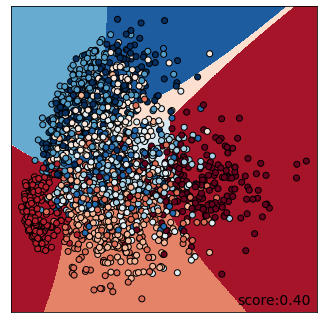

In [31]:
m, n = training_feat.shape
plotDecisionBoundary(mlp, training_feat, m,
                     score=(preds == y_test).mean(),
                     title="")